# Statistical Anomaly Detection on Machine Temperature Data

This notebook applies statistical anomaly detection methods to the NAB machine-temperature dataset.  
Statistical approaches are fast, interpretable, and useful as baselines before moving to ML or DL.

Their main drawback is sensitivity to noise and lack of contextual awareness: a point can look “normal” globally yet be anomalous relative to its neighborhood.

## Methods Considered

- **Global / robust detectors**
  - Z-score: flags points that are k standard deviations from the mean.
  - IQR (Interquartile Range): flags values outside \[Q1 − 1.5×IQR, Q3 + 1.5×IQR].
  - MAD (Median Absolute Deviation): robust z-score using medians.

- **Sequential / local change detectors**
  - CUSUM: cumulative sum change detector; sensitive to mean shifts.
  - EWMA (Exponentially Weighted Moving Average): smooths noise to detect gradual shifts.
  - Percentage change: flags large point-to-point variations.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pathlib

repo_root = pathlib.Path.cwd().resolve().parents[1]  
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# utils from this repo
from configs.config import DEFAULTS
from src.data_loader import load_dataset
from src.detectors_stats import run_detectors
from src.visualizations import plot_methods_subplots 
from src.evaluation import evaluate_predictions


## Load Dataset

In [2]:
dfs, merged, failure_windows= load_dataset("machine_temperature")
df = dfs[0]

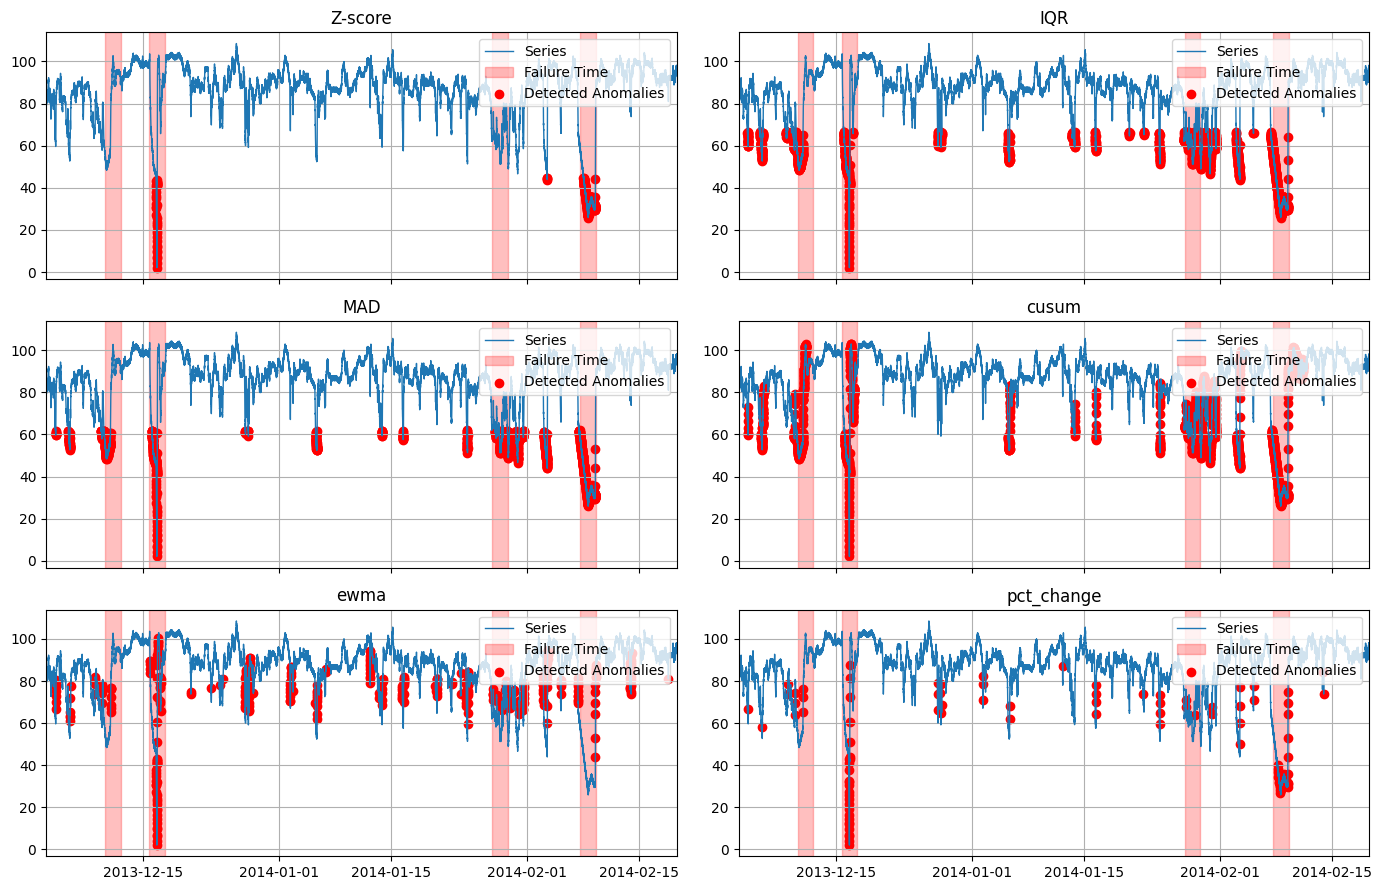

In [3]:
results = run_detectors(df, "machine_temperature_system_failure", DEFAULTS)
methods_preds = {name: res["mask"].astype(int) if "mask" in res else None
                 for name,res in results["per_method"].items()}
plot_methods_subplots(df, methods_preds, offset = 0, value_col="machine_temperature_system_failure", windows=failure_windows)

In [4]:
eval_results = {}
for name, res in results["per_method"].items():
    if "mask" in res:
        eval_results[name] = evaluate_predictions(df, res['mask'], failure_windows, early_tolerance="5h")
        
print(pd.DataFrame(eval_results).T.round(3).sort_values('f1', ascending=False))

                tp      fp      fn       tn  precision  recall     f1  \
cusum       1688.0  1366.0   580.0  19061.0      0.553   0.744  0.634   
IQR         1333.0   965.0   935.0  19462.0      0.580   0.588  0.584   
MAD         1126.0   622.0  1142.0  19805.0      0.644   0.496  0.561   
Z-score      458.0     4.0  1810.0  20423.0      0.991   0.202  0.336   
ewma         101.0   262.0  2167.0  20165.0      0.278   0.045  0.077   
pct_change    83.0    39.0  2185.0  20388.0      0.680   0.037  0.069   

            anomaly_window_detection_rate  early_detection_rate  
cusum                                 1.0                  0.50  
IQR                                   1.0                  0.75  
MAD                                   1.0                  0.50  
Z-score                               0.5                  0.00  
ewma                                  1.0                  0.00  
pct_change                            1.0                  0.00  


## Performance Summary

- CUSUM delivered the highest recall and F1, catching more anomalous points at the cost of extra false positives. It reached full anomaly window detection (1) with a moderate early detection rate (0.50).

- IQR showed the best overall balance of precision and recall, making it the most reliable statistical baseline. It achieved full anomaly window detection rate (1), detecting all four windows, and had the highest early detection rate (0.75). 

- MAD offered the highest precision among the robust baselines but with lower recall, making it a conservative choice. It maintained full window detection (1) and a mid-level early detection rate (0.50). 

- Z-score acted as a very strict detector, achieving near-perfect precision but missing many anomalies. It detected only half of the windows (0.5) and provided no early warnings (0). 

- EWMA had very low pointwise recall and did not provide early warnings, despite occasionally hitting all windows (coverage 1). 

- Percentage change similarly showed low recall with no early warnings, even though it detected all windows (coverage 1). 

**Takeaway:** Prioritize CUSUM (maximum recall/F1) and IQR (fastest with balanced trade-offs), with MAD as a high-precision option. Z-score, EWMA, and pct change aren’t sufficient on their own for these sudden failures.

### Metric Review
- Precision – Of all the points flagged as anomalies, how many were correct.
- Recall – Of all true anomaly points, how many were detected.
- F1-score – representing both precision and recall, balancing the trade-off.
- Anomaly Window Detection Rate – Fraction of anomaly windows (here, 4 total) where the detector caught at least one anomaly.
- Early Detection Rate – Fraction of anomaly windows where the detector raised a flag earlier than the labeld failure window.